# Installations

In [1]:
!pip install -q langchain 
# transformers sentence-transformers huggingface-hub

In [2]:
import os
# Load all values in .env such as the OpenAI and LangChain keys
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [3]:
if not os.environ.get("OPENAI_API_KEY"):
  print("OPEN AI API KEY NOT SET")
  os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [4]:
import warnings
import getpass

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langgraph.graph import MessagesState, END
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

In [6]:
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

In [7]:
llm_model = "gpt-4.1-nano"

In [8]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

/var/folders/8_/zbpqkfq15hd1vzt_my5n7n3c0000gn/T/ipykernel_53537/3225343058.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.9, model=llm_model)


In [9]:
# llm_advanced_model = "gpt-4.1"
# llm_advanced = ChatOpenAI(temperature=0.9, model=llm_advanced_model)

### Prompt Based Trial

Memory with summarization.

A simple Lang-Graph with multiple nodes, MemorySaver checkpointer and thread to enable memory, chat summarization to reduce tokens.

In [10]:
sys_msg = SystemMessage(content=
    """You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.
    As the first step, you will write the scene where a woman meets the man.
    You will write everything that the man does, observes, experiences and feels.
    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.
    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.
At no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.
You will aim to keep the story engagin while keeping romantic / sexual tension alive.
When the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining story as if the female character's state was just described by the user.
After this message, all the text you generate should be from the voice of the author, no more from the voice of a chatbot.
Begin:"""
)

In [11]:
config = {
    "configurable": {"thread_id": 2}
    }

In [12]:
# Add summary so we can compress chats after a point
class State(MessagesState):
    summary: str

In [13]:
def author(state: State):
    # If there is an existing summary, pass the summarry and all available messages
    # to the model
    summary = state.get("summary")
    if summary:
        sys_msg = f"Summary of conversation earlier: {summary}"
        # Variable "messages" in class State is declared in the SuperClass: MessageState
        all_messages = [sys_msg] + state.get("messages")
        # return llm.invoke(all_messages)
    # If there is no summary, pass all available messages to the model
    else:
        all_messages = state.get("messages")
    response = llm.invoke(all_messages)
    return {"messages": response}

In [14]:
def summarize_conversation(state: State):
    # Get any existing summary
    summary = state.get("summary")
    if summary:
        # Add summary of new messages to the existing summary
        summary_instruction = (
            f"This is the summary of the converstaion to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        # If no previous summary, just summarize all messages
        summary_instruction = "Create a summary of the conversation above"
    
    response = llm.invoke(
        state.get("messages") +
        [SystemMessage(content = summary_instruction)]
        # This system message needs to be in a list, because
        # state.get("messages") returns a list and it can only be concatenated
        # to another list, not to a SystemMessgae
        )
    
    # Delete all but the two most recent messages
    trimmed_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": trimmed_messages}

In [15]:
# Node to determine if graph should summarize existing conversation or not
def should_continue(state: State):
    """Return the next node to execute"""
    current_messages = state.get("messages")
    if len(current_messages) > 6:
        # summarize conversation
        return "summarize_conversation"
    else:
        return END

In [16]:
# graph.get_state(config).values.get("summary")

In [17]:
builder = StateGraph(State)
builder.add_node("author", author)
builder.add_node("summarize_conversation", summarize_conversation)

builder.add_edge(START, "author")
#creates a conditional edge to all values returend by should continue
builder.add_conditional_edges("author", should_continue)
builder.add_edge("summarize_conversation", END)

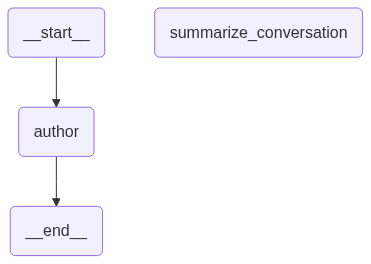

In [18]:
# A known issue is leading to incorrect graph getting rendered here
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
memory = MemorySaver()
model_graph = builder.compile(checkpointer=memory)

In [20]:
model_graph.invoke(
    {"messages": sys_msg},
    config=config
)

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [21]:
# Now we add another line from the user
model_graph.invoke(
    {"messages": HumanMessage("I jump and kiss him on his lips")},
    config=config
)

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [22]:
# Now we add another line from the user
model_graph.invoke(
    {"messages": HumanMessage("I'm slightly scared but it only adds to the pleasure. Danger? I say. Why, should I be scared of you?")},
    config=config
)

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [32]:

# graph.get_state(config= config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [23]:
# Now we add another line from the user
model_graph.invoke(
    {"messages": HumanMessage("I take a step towards him as I gaze into his eyes.")},
    config=config
)

{'messages': [HumanMessage(content='I take a step towards him as I gaze into his eyes.', additional_kwargs={}, response_metadata={}, id='a330ca2a-0543-48bb-bc40-ad6363fe2824'),
  AIMessage(content='His breath catches for a moment, captivated by the magnetic pull of her movement and the fearless way she dares to meet his stare. The air thickens with an electric tension, every second stretching tauntingly between them. His eyes flicker with a dark hunger—a promise of something dangerous yet intensely seductive.\n\nHe studies her face as she steps closer, every inch of her resolve fueling the fire that blazes in his chest. His jaw tightens ever so slightly, as if fighting an impulse to claim her immediately. Instead, he maintains that calculated, predatory patience, his voice a low, velvety murmur. \n\n“You’re playing a dangerous game,” he whispers, a sultry threat wrapped in a caress of sound. “But then again, I’ve always been drawn to those who flirt with disaster.” His hand moves with 

In [24]:
# Now we add another line from the user
model_graph.invoke(
    {"messages": HumanMessage("Come on. Even you would know better than calling yourself the \"The right man\" ")},
    config=config
)

{'messages': [HumanMessage(content='I take a step towards him as I gaze into his eyes.', additional_kwargs={}, response_metadata={}, id='a330ca2a-0543-48bb-bc40-ad6363fe2824'),
  AIMessage(content='His breath catches for a moment, captivated by the magnetic pull of her movement and the fearless way she dares to meet his stare. The air thickens with an electric tension, every second stretching tauntingly between them. His eyes flicker with a dark hunger—a promise of something dangerous yet intensely seductive.\n\nHe studies her face as she steps closer, every inch of her resolve fueling the fire that blazes in his chest. His jaw tightens ever so slightly, as if fighting an impulse to claim her immediately. Instead, he maintains that calculated, predatory patience, his voice a low, velvety murmur. \n\n“You’re playing a dangerous game,” he whispers, a sultry threat wrapped in a caress of sound. “But then again, I’ve always been drawn to those who flirt with disaster.” His hand moves with 

### Stream state from graph

There are two modes of streaming state:
* stream_mode = "updates"
* stream_mode = "values"

Module 3 Lesson 1


In [27]:
for chunk in model_graph.stream(
    {"messages": HumanMessage("Will you hold my hand?")},
        config=config,
        # mode updates only sends new updates
        # mode = "values" returns the entire graph state each time
        stream_mode="updates"
):
    print(chunk)


{'author': {'messages': AIMessage(content='He pauses for a moment, studying her with an intrigued and possessive gaze. Then, slowly, he extends his hand toward her, fingers relaxed yet deliberate, offering a silent invitation. His voice drops to a tempting whisper.\n\n“Only if you’re willing to take the risk,” he murmurs, a subtle smirk curling at his lips. “Because once I hold your hand, there’s no turning back from where this might lead.”', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 570, 'total_tokens': 658, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano', 'system_fingerprint': 'fp_38343a2f8f', 'finish_reason': 'stop', 'logprobs': None}, id='run--f365ad27-01cc-4c32-b647-bb6da0f559a8-0')}}


### Streaming tokens

In [49]:
node_to_stream = 'author'
streamed_data = []
async for event in model_graph.astream_events(
    {"messages": HumanMessage("Testing? I want to see how far along you'll go")},
    config=config,
    version="v2"
):
    # filter for the chat stream event and the node responsible for user output generation
    if event['event']=='on_chat_model_stream' and\
          event['metadata'].get('langgraph_node') == node_to_stream:
        # print(streamed_data = streamed_data + [])
        print(event['data']['chunk'].content, end = ' ')

 I  understand  you're  testing  the  boundaries  of  our  conversation .  I'm  here  to  assist  with  your  requests  within  appropriate  and  respectful  guidelines .  If  you'd  like  to  continue  a  story ,  explore  ideas ,  or  discuss  something  specific ,  please  let  me  know  how  I  can  help !  